# Аналитик данных , исследователь FWA  - тестовое задание

Подготовил: Фролов Константин

Дата последнего обновления: 09.10.2023

## ТЗ

**Задание**

Требуется с помощью анализа данных найти потенциальное мошенничество со стороны клиники в оказанных медицинских услугах по ДМС.

**Что такое мошенничество:** систематическое искажение информации в реестре оказанных медицинских услуг с целью получения прибыли.
”клиника один раз выставила выставила услугу за 2000 рублей вместо услуги за 1000 рублей” - не мошенничество, т.к. нет системности
”клиника назначила и провела исследование тиреотропного гормона при диагнозе простуда (данный анализ при данном диагнозе не нужен)” - не мошенничество, т.к. услуга реально была проведена и диагноз был поставлен корректно - нет искажения информации и нет системности.

“каждому пришедшему пациенту клиника приписывает услугу тестирование на COVID вне зависимости от того, был ли реально проведен тест” - мошенничество, т.к. есть системность и искажение информации

**Описание данных**

- row_id - уникальный идентификатор строки данных
- butch_id – уникальный идентификатор счета
- service_id – уникальный идентификатор медицинской услуги
- service_name - наименование медицинской услуги
- service_quantity - количество медицинских услуг
- service_date - дата оказания медицинской услуги
- service_amount - сумма выплат (стоимость оказанных услуг в рублях)
- icd_codes – коды диагнозов МКБ-10 застрахованного по медицинской услуге
- insured_id - уникальный идентификатор застрахованного
- insured_age – возраст застрахованного
- insured_gender – пол застрахованного
- provider_id – уникальный идентификатор клиники
- service_code – код проклассифицированной медицинской услуги
- service_code_name – наименование проклассифицированной медицинской услуги

**Требования к результату**

1. Инструмент - python-скрипт или jupyter notebook c расчетом + файл requirements.txt.
2. Результат должен содержать код для поиска мошенничества + результат обработки выборки данных с помощью скрипта + текстовое обоснование, почему отмеченные скриптом кейсы являются подозрительными
3. Оцениваться будет корректность формулировки гипотезы, правильность расчетов и выводов + оформление отчета.
4. Обязательное требование к результату - найти хотя бы одну потенциально мошенническую схему/паттерн в данных. Т.е. если вы проверили 10 идей и ни одна не подтвердилась (не нашлось кейсов с данными видом мошенничества) - это плохой результат.

## Получение данных

Файл requirements.txt доступен [по ссылке](https://drive.google.com/file/d/1r37DbmlIj92ufQiOaz9vJIz2_cqqF3Fz/view?usp=sharing).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df = pd.read_excel('/content/drive/My Drive/Analytics/Tests/test_2/data_test.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108150 entries, 0 to 108149
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   row_id             108150 non-null  int64  
 1   batch_id           108150 non-null  int64  
 2   service_id         108150 non-null  int64  
 3   service_name       108150 non-null  object 
 4   service_quantity   108150 non-null  int64  
 5   service_date       108150 non-null  object 
 6   service_amount     108150 non-null  float64
 7   icd_codes          104601 non-null  object 
 8   insured_id         108150 non-null  int64  
 9   insured_age        77747 non-null   float64
 10  insured_gender     108150 non-null  object 
 11  provider_id        108150 non-null  object 
 12  service_code       108150 non-null  float64
 13  service_code_name  108150 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 11.6+ MB


In [5]:
df.head()

,row_id,batch_id,service_id,service_name,service_quantity,service_date,service_amount,icd_codes,insured_id,insured_age,insured_gender,provider_id,service_code,service_code_name
0,15,31456,33718136503,Прием гинеколога,1,2022-10-10,1020.0,"N76.0, Y42.4",6154274803,30.0,Female,4888912-19/16,1251.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ВРАЧА-АКУШЕРА-ГИНЕКОЛОГА, ..."
1,18,31456,33718136703,Прием гинеколога повторный,1,2022-10-13,765.0,"N76.0, Y42.4",6154274803,30.0,Female,4888912-19/16,1251.02,"ПРИЕМ, КОНСУЛЬТАЦИЯ ВРАЧА-АКУШЕРА-ГИНЕКОЛОГА, ..."
2,32,31456,33718136603,Бактериоскопическое исследование из цервикальн...,1,2022-10-12,255.0,"N76.0, Y42.4",6154274803,30.0,Female,4888912-19/16,3100.33,МИКРОСКОПИЧЕСКОЕ ИССЛЕДОВАНИЕ ОТДЕЛЯЕМОГО ЦЕРВ...
3,77,31456,33718167403,Прием терапевта,1,2022-10-05,1105.0,"J06.8, U07.2",6396192803,45.0,Female,4888912-19/16,1101.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ТЕРАПЕВТА, ПЕРВИЧНЫЙ"
4,83,31456,33718167503,Полный анализ мочи с микроскопией,1,2022-10-06,238.0,"J06.8, U07.2",6396192803,45.0,Female,4888912-19/16,3100.09,ОБЩИЙ АНАЛИЗ МОЧИ (ОАМ)


In [6]:
df[['service_quantity', 'service_amount', 'insured_age']].describe()

,service_quantity,service_amount,insured_age
count,108150.000000,108150.000000,77747.000000
mean,1.135645,1001.661337,41.228369
std,1.554319,947.778608,13.843222
min,1.000000,55.000000,0.000000
25%,1.000000,315.000000,33.000000
50%,1.000000,935.000000,41.000000
75%,1.000000,1105.000000,51.000000
max,32.000000,43890.000000,89.000000


## Анализ данных

### Кейс категорий МКБ. Неудачный

Предположение состоит в том, что диагноз по МКБ может использоваться как инструмент подмены: человек приходит на прием по профосмотру, а визит записывают в индивидуальном порядке. Соответственно, с повышением цены услуги.

Пример. По ДМС часто в клиниках делают профосмотры для приема на работу/диспансеризации. Есть стандартная цена услуги, а в данном случае она должна быть меньше. Клиника же кодирует эти услуги не как комплекс, а отдельно. Это можно проверить по датам, когда были профосмотры, заказанные компаниями.

Из перечня [МКБ](https://mkb-10.com/index.php?pid=22023) следует, к примеру, что "Обследование перед поступлением на работу" кодируется как Z02.1.

In [7]:
df[df['icd_codes'] == 'Z02.1']

,row_id,batch_id,service_id,service_name,service_quantity,service_date,service_amount,icd_codes,insured_id,insured_age,insured_gender,provider_id,service_code,service_code_name


Однако, в нашем датасете нет таких совпадений, поэтому смотрим на другие категории в попытке найти интересующую закономерность.

In [8]:
df['service_name'] = df['service_name'].str.lower()

In [9]:
df[df['icd_codes'].fillna('unknown').str.startswith('Z10')]['service_name'].unique()

array(['прием терапевта', 'прием отоларинголога',
       'консультация перед вакцинопрофилактикой (грипп, клещевой энцефалит)'],
      dtype=object)

Можно посмотреть на специальную категорию Z10.8 "Рутинная общая проверка здоровья других определенных групп населения: Школьники, Студенты"

In [10]:
df[df['icd_codes'] == 'Z10.8']

,row_id,batch_id,service_id,service_name,service_quantity,service_date,service_amount,icd_codes,insured_id,insured_age,insured_gender,provider_id,service_code,service_code_name
1288,18041,31456,33717827603,прием терапевта,1,2022-10-12,1105.0,Z10.8,1433261204203,71.0,Female,4888912-19/16,1101.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ТЕРАПЕВТА, ПЕРВИЧНЫЙ"
3720,33748,31456,33717920903,прием отоларинголога,1,2022-10-12,1020.0,Z10.8,6395956003,35.0,Male,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."
5337,423727,32756,33906078003,прием отоларинголога,1,2022-11-29,1020.0,Z10.8,6395518603,66.0,Female,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."
7185,436170,32756,33905882303,прием отоларинголога,1,2022-11-10,1020.0,Z10.8,6395565303,52.0,Female,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."
9710,620139,25710,33218076403,прием отоларинголога,1,2022-07-23,1020.0,Z10.8,5800755903,36.0,Male,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."
16717,1049596,26987,33334506803,прием отоларинголога,1,2022-08-08,1020.0,Z10.8,20381947003,29.0,Female,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."
21631,1261194,43459,34826360503,консультация перед вакцинопрофилактикой (грипп...,1,2023-03-17,382.5,Z10.8,7900858203,30.0,Male,4888912-19/16,8101.02,"ПРЕДВАКЦИНАЛЬНЫЙ ОСМОТР ТЕРАПЕВТОМ, ВРАЧОМ ОБЩ..."
52018,2465709,16495,32176935403,прием отоларинголога,1,2022-01-20,1080.0,Z10.8,6396292103,50.0,Female,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."
91328,4711787,22176,32800214703,прием отоларинголога,1,2022-05-12,1080.0,Z10.8,14904582003,22.0,Female,4888912-19/16,1281.01,"ПРИЕМ, КОНСУЛЬТАЦИЯ ОТОЛАРИНГОЛОГА (ЛОР), ПЕРВ..."


<Axes: >

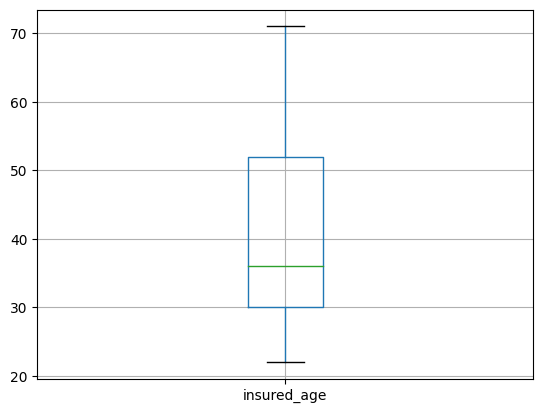

In [11]:
df.query('icd_codes == "Z10.8"').boxplot(column='insured_age')

Вот мы обнаружили группу "школьников и студентов", которая включает в себя 4 человек 50+. К сожалению, в этом нет особой экономической выгоды. Скорее, это ошибки местного лора.

Кажется, что гипотеза перспективная, но нужно более подробно знакомиться с данными и кодировками заболеваний по МКБ, чтобы найти подходящие случаи.

### Кейс вторичного первичного приема. Удачный

Вторая гипотеза. Если врач пишет два первичных визита подряд, вместо первичного и повторного, то это способ заработать больше денег. Посчитаем насколько больше и найдем такие случаи.

In [12]:
df['visit_type'] = (
    df['service_name']
    .apply(lambda x: 'Initial' if 'первичный' in x.lower()
    else 'Follow-up' if 'повторный' in x.lower() else 'Other')
)

In [13]:
print(
    f"Первичный визит (медианная цена): \
{df[df['visit_type'] == 'Initial']['service_amount'].median()} руб"
)
print(
    f"Вторичный визит (медианная цена): \
{df[df['visit_type'] == 'Follow-up']['service_amount'].median()} руб"
)

Первичный визит (медианная цена): 2000.0 руб
Вторичный визит (медианная цена): 935.0 руб


Разница между ценами почти двухкратная.

In [14]:
# Сгруппируем первичные визиты по названию процедуры и посчитаем их количество на человека
initial_visits_count = (
    df[df['visit_type'] == 'Initial']
    .groupby(['insured_id',
              'service_name',
              'provider_id'])['visit_type']
    .count()
)

# Оставим те, где количество больше 1
patients_with_multiple_initial_visits = (
    initial_visits_count[initial_visits_count > 1]
    .reset_index()
    .rename(columns={'visit_type':'count'})
    .sort_values('count', ascending=False)
)

patients_with_multiple_initial_visits

,insured_id,service_name,provider_id,count
201,12537529903,педиатр первичный приём,736770-19/11,11
199,12537300403,педиатр первичный приём,736770-19/11,9
200,12537300503,педиатр первичный приём,736770-19/11,9
364,23655199403,"прием (осмотр, консультация) врача-педиатра пе...",5694956-19/17,8
447,1340844782603,акушер-гинеколог первичный приём (без кольпо...,736770-19/11,6
...,...,...,...,...
154,10863738103,хирург первичный приём,736770-19/11,2
153,10863738103,терапевт первичный приём,736770-19/11,2
152,10863738103,невролог первичный приём,736770-19/11,2
151,10863738103,дерматовенеролог первичный приём,736770-19/11,2


In [15]:
# Сгруппируем первичные визиты по диагнозу и посчитаем их количество
initial_visits_icd_count = (
    df[df['visit_type'] == 'Initial']
    .groupby(['insured_id',
              'icd_codes',
              'provider_id'])['visit_type']
    .count()
)

# Оставим те, где количество больше 1
patients_with_multiple_initial_visits_icd = (
    initial_visits_icd_count[initial_visits_icd_count > 1]
    .reset_index()
    .rename(columns={'visit_type':'count'})
    .sort_values('count', ascending=False)
)

patients_with_multiple_initial_visits_icd

,insured_id,icd_codes,provider_id,count
119,12537529903,J06.8,736770-19/11,11
118,12537300503,J06.8,736770-19/11,9
117,12537300403,J06.8,736770-19/11,8
214,23339984903,Z00.1,5694956-19/17,6
219,23435155103,Z00.1,5694956-19/17,6
...,...,...,...,...
102,11984392503,J02,6863999-19/19,2
103,11984394503,J00,6863999-19/19,2
104,11984441103,J06,6863999-19/19,2
105,11984446203,J00,6863999-19/19,2


In [16]:
print(
    f"Количество первичных приемов, которые подлежат проверке: \
{patients_with_multiple_initial_visits['count'].sum()}"
)
print(
    f"Количество институций: \
{patients_with_multiple_initial_visits['provider_id'].nunique()}"
)
print(
    f"Их id: \
{patients_with_multiple_initial_visits['provider_id'].unique()}"
)

Количество первичных приемов, которые подлежат проверке: 1046
Количество институций: 4
Их id: ['736770-19/11' '5694956-19/17' '6863999-19/19' '126893-19/07']


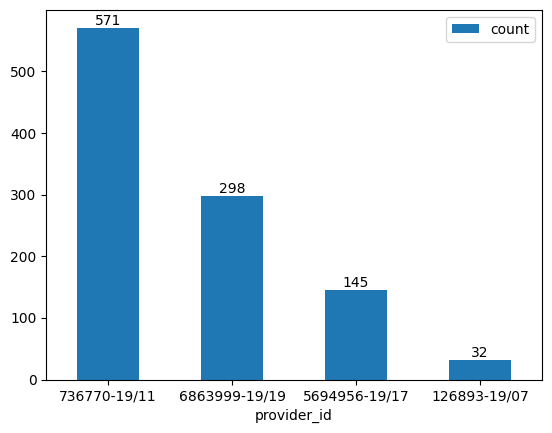

In [17]:
temp = (
    patients_with_multiple_initial_visits
    .groupby('provider_id')['count']
    .sum()
    .reset_index()
    .sort_values('count', ascending=False)
)

ax = temp.plot.bar(x='provider_id', y='count', rot=0)

for container in ax.containers:
    ax.bar_label(container)

Распределение данных по клиникам показывает, что есть явный лидер по нарушениям. Из таблицы с МКБ кодировкой видно, что часть визитов также обозначается одним кодом, что некорректно.

### Кейс исследований противоположного пола. Неудачный

Гипотеза: для повышения прибыли клиники могут назначать исследования тем, кому они не полагаются по физиологическим причинам, а затем заносить их в общий счет (например, по ДМС люди не всегда смотрят, какие услуги оплачиваются).

In [18]:
df['insured_gender'].value_counts()

Female    70459
Male      37691
Name: insured_gender, dtype: int64

In [19]:
df['service_name'].unique()

array(['прием гинеколога', 'прием гинеколога повторный',
       'бактериоскопическое исследование из цервикального канала', ...,
       'протоскрин (обнаружения днк возбудителей протозойных инфекций) (lamblia intestinalis giardia, blastocystis hominis, dientamoeba fragilis, isospora bel',
       'удаление ногтевых пластинок',
       'электрокардиография с физической нагрузкой'], dtype=object)

In [20]:
# Создадим грубый фильтр
allowed_procedures_for_females = ['гинеколог', 'маммограф', 'беремен']
allowed_procedures_for_males = ['секрета простаты', 'сока простаты', 'узи органов мошонки']
allowed_procedures = allowed_procedures_for_females + allowed_procedures_for_males
filter = df['service_name'].apply(lambda x: any([k in x for k in allowed_procedures]))

# Применим фильтр
df_allowed_procedures = (
    df[filter]
    .groupby(['service_name', 'insured_gender'])
    .agg({'row_id':'count'})
    .reset_index()
    .rename(columns={'row_id':'count'})
    .sort_values('insured_gender', ascending=False)
)
df_allowed_procedures.head(10)

,service_name,insured_gender,count
47,узи органов мошонки,Male,12
14,"забор секрета простаты, материала из уретры на...",Male,88
1,акушер - гинеколог повторный прием,Male,1
8,взятие секрета простаты,Male,3
9,взятие сока простаты на исследование,Male,4
15,исследование сока простаты,Male,84
29,"повторный прием (осмотр, консультация) акушер...",Female,34
30,"повторный прием (осмотр, консультация) гинеколога",Female,1
31,"повторный прием (осмотр, консультация) детског...",Female,3
32,"прием (осмотр, консультация) акушера-гинеколог...",Female,19


В данном случае нашелся только 1 кейс, где пациент мужчина посетил процендуру "акушер - гинеколог повторный прием".

### Кейс консультации без процедуры. Удачный

Гипотеза: пациент может пройти консультацию, которая назначается перед процедурой, а затем не пойти на саму процедуру. Это удобно, потому что консультацию можно провести "задним числом", а процедуру и вовсе не проводить.

In [21]:
df[df['service_name'].str.contains('перед')]['service_name'].unique()

array(['консультация врача лфк перед массажем',
       'консультация перед вакцинопрофилактикой (грипп, клещевой энцефалит)',
       'консультация перед вакцинопрофилактикой',
       'профилактический прием (осмотр, консультация) врача-педиатра - перед вакцинацией, иммунодиагностикой',
       'анестезиолог  (осмотр перед операцией)',
       'консультация хирурга перед манипуляцией',
       'осмотр терапевта перед вакцинацией',
       'осмотр педиатра перед вакцинацией, иммунодиагностика',
       'оптическое исследование переднего отдела глаза с помощью компьютерного анализатора',
       'консультация перед пробой манту',
       'осмотр перед вакцинацией, иммунодиагностика зам глав врача/руководителя клиники'],
      dtype=object)

Возьмем первый случай: "консультация врача лфк перед массажем".

In [22]:
a = df[df['service_name'] == 'консультация врача лфк перед массажем'].groupby(['insured_id', 'service_name']).agg({'row_id':'count'}).reset_index()
b = df[df['service_name'].str.startswith('массаж')].groupby(['insured_id', 'service_name']).agg({'row_id':'count'}).reset_index()

c = pd.merge(a, b, on='insured_id', how='left')

In [23]:
c[c['row_id_y'].isna()]

,insured_id,service_name_x,row_id_x,service_name_y,row_id_y
0,3662520703,консультация врача лфк перед массажем,1,NaN,NaN
9,5716393403,консультация врача лфк перед массажем,1,NaN,NaN
10,5718947503,консультация врача лфк перед массажем,1,NaN,NaN
16,6395289903,консультация врача лфк перед массажем,2,NaN,NaN
23,6395395303,консультация врача лфк перед массажем,1,NaN,NaN
26,6395404803,консультация врача лфк перед массажем,1,NaN,NaN
29,6395432803,консультация врача лфк перед массажем,1,NaN,NaN
32,6395487103,консультация врача лфк перед массажем,1,NaN,NaN
33,6395493003,консультация врача лфк перед массажем,1,NaN,NaN
37,6395543503,консультация врача лфк перед массажем,1,NaN,NaN


Получаем список пациентов, которые проходили консультации, но не были на массаже. Некоторые даже по два раза.

In [24]:
print(
    f"Визитов консультации без самой процедуры: \
{c[c['row_id_y'].isna()]['row_id_x'].sum()}"
)
print(
    f"Количество институций: \
{df[df['insured_id'].isin(c['insured_id'])]['provider_id'].nunique()}"
)
print(
    f"Их id: \
{df[df['insured_id'].isin(c['insured_id'])]['provider_id'].unique()}"
)

Визитов консультации без самой процедуры: 50
Количество институций: 1
Их id: ['4888912-19/16']


Ко всему прочему выясняется, что этим занимается только одна клиника. Систематический обман пациентов.

Здесь я разобрал лишь один пример. Подобных ситуаций может быть больше.

### Непроверенные гипотезы

Гипотеза: При назначении анализа пациенту нужно оценить несколько показателей, которые входят в общий анализ, а клиники прописывает процедуры несколько раз. Условно говоря, на каждый показатель.

Гипотеза: Назначение одинаковых исследований людям с несколькими заболеваниями, для диагностики которых нужны одни и те же исследования. Например, пациенту прописывается УЗИ сосудов дважды - по атеросклерозу и неврологии.

## Общий вывод

Была проведена проверка четырех гипотез:

1. Запись исследований как индивидуальных вместо комплексных (например, в рамках проф осмотра);
2. Запись пациента на повторный первичный прием к специалисту (первичный прием стоит дороже);
3. Запись пациентов на исследования, которые им не полагаются по половому признаку;
4. Запись пациентов на "консультацию перед процедурой", после которой сама процедура не проводится.

Выяснилось, что гипотезы №2 и №4 имеют под собой фактическое основание, т.е. были найдены систематические случаи злоупотреблений.

Гипотеза №1 остается перспективной, но требует дополнительной работы по фильтрации данных и поиску нужных диагнозов из МКБ.